# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import math

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Reds' # change to Reds cmap

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


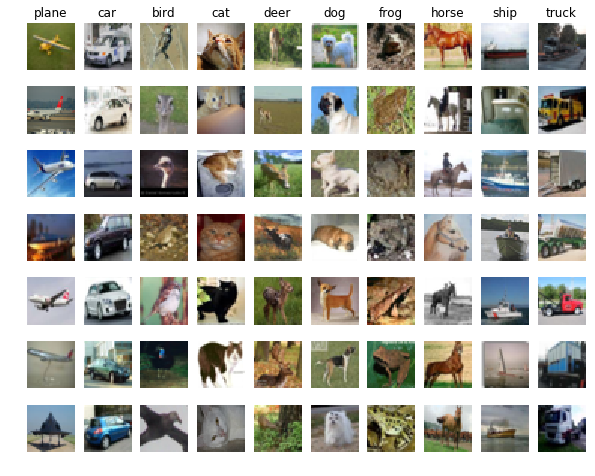

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(32,32,3).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


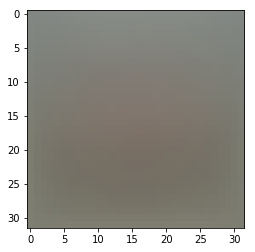

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.195383


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [12]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 30.901624 analytic: 30.901624, relative error: 5.801369e-12
numerical: 3.611535 analytic: 3.611535, relative error: 4.772821e-11
numerical: -11.264872 analytic: -11.264872, relative error: 1.720295e-11
numerical: 2.396820 analytic: 2.396820, relative error: 7.975973e-11
numerical: 19.711871 analytic: 19.711871, relative error: 7.496217e-12
numerical: -38.050656 analytic: -38.050656, relative error: 4.855136e-15
numerical: -0.313623 analytic: -0.313623, relative error: 2.831161e-10
numerical: 20.073517 analytic: 20.073517, relative error: 4.700521e-11
numerical: -2.167983 analytic: -2.167983, relative error: 3.392557e-11
numerical: -1.328504 analytic: -1.328504, relative error: 3.612983e-10
numerical: -2.543682 analytic: -2.543682, relative error: 1.181372e-10
numerical: 26.630925 analytic: 26.630925, relative error: 8.611863e-12
numerical: -1.153517 analytic: -1.153517, relative error: 1.431972e-10
numerical: 17.786216 analytic: 17.786216, relative error: 1.941804e-11
numeri

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *It can happen when the value of the function [max(0, function(x))] changes from negative to positive within the 2h increment of x in numerical evaluation of the gradient. One example is when the value of the function at x equals zero.*

In [13]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.195383e+00 computed in 0.034089s
Vectorized loss: 9.195383e+00 computed in 0.003509s
difference: -0.000000


In [14]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.038575s
Vectorized loss and gradient: computed in 0.003011s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [15]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 791.002844
iteration 100 / 1500: loss 288.886615
iteration 200 / 1500: loss 107.802847
iteration 300 / 1500: loss 42.835320
iteration 400 / 1500: loss 19.065717
iteration 500 / 1500: loss 10.086220
iteration 600 / 1500: loss 7.012707
iteration 700 / 1500: loss 5.487072
iteration 800 / 1500: loss 5.622449
iteration 900 / 1500: loss 5.426645
iteration 1000 / 1500: loss 5.648924
iteration 1100 / 1500: loss 5.404898
iteration 1200 / 1500: loss 5.293512
iteration 1300 / 1500: loss 5.242103
iteration 1400 / 1500: loss 5.668258
That took 6.038039s


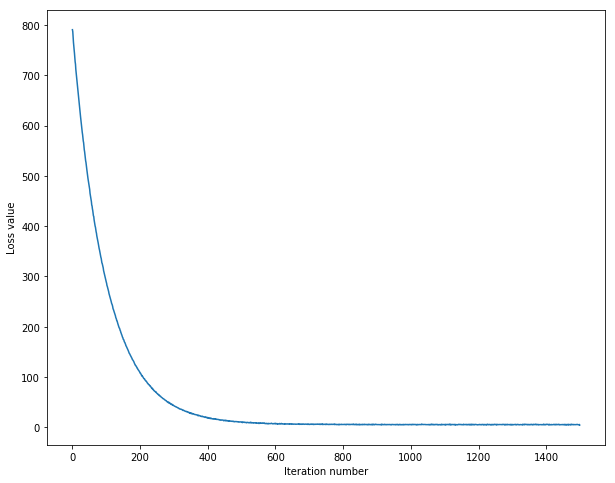

In [16]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [17]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368347
validation accuracy: 0.364000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
n_params = 20
learning_rates = np.power(10, np.random.uniform(-8,-5, size=n_params))
regularization_strengths = np.power(10, np.random.uniform(2.5,5.5, size=n_params))
params = [(learning_rates[i], regularization_strengths[i]) for i in range(n_params)]
################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
svm = LinearSVM()
svm.cross_val(X_train, y_train, X_val, y_val, params, num_iters=1225)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 1.127089e-07 reg 1.626675e+04 train accuracy: 0.376816 val accuracy: 0.373000
lr 1.932978e-07 reg 1.622677e+04 train accuracy: 0.372041 val accuracy: 0.382000
lr 6.460159e-08 reg 1.844430e+04 train accuracy: 0.376816 val accuracy: 0.378000
lr 1.018733e-07 reg 2.907409e+04 train accuracy: 0.365184 val accuracy: 0.383000
lr 2.349462e-06 reg 4.036428e+04 train accuracy: 0.206857 val accuracy: 0.218000
lr 4.816483e-07 reg 1.957879e+03 train accuracy: 0.361959 val accuracy: 0.361000
lr 4.029820e-08 reg 1.765939e+03 train accuracy: 0.277429 val accuracy: 0.303000
lr 3.079309e-08 reg 2.339822e+05 train accuracy: 0.325204 val accuracy: 0.341000
lr 8.992001e-07 reg 2.200195e+04 train accuracy: 0.295551 val accuracy: 0.315000
lr 1.157723e-06 reg 7.300927e+03 train accuracy: 0.296490 val accuracy: 0.310000
lr 2.329563e-06 reg 2.807723e+04 train accuracy: 0.234612 val accuracy: 0.237000
lr 8.501608e-08 reg 5.825481e+04 train accuracy: 0.357429 val accuracy: 0.369000
lr 5.073145e-06 reg 7.306620

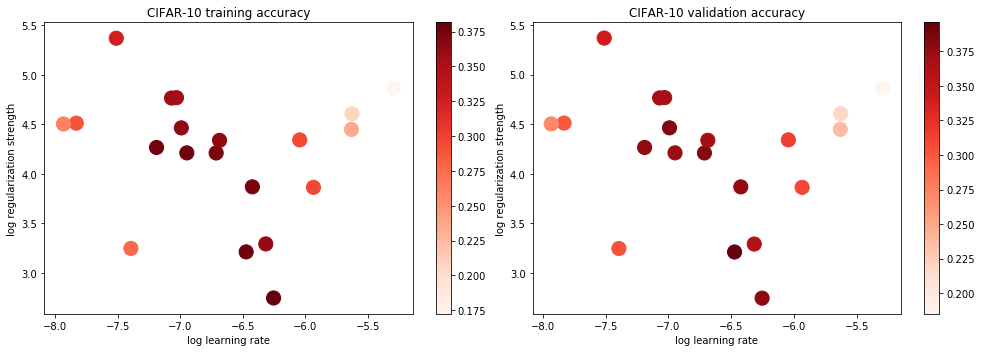

In [24]:
results = svm.results

# Visualize the cross-validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

plt.figure(figsize=(14,5))
# plot training accuracy
marker_size = 200
colors = [results[x][0] for x in results]
plt.subplot(1, 2, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.tight_layout() # tight layout

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(1, 2, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout() # tight layout
plt.show()

In [25]:
# Fine tune parameters
n_params = 20
learning_rates = np.power(10, np.random.uniform(-7.5,-6, size=n_params))
regularization_strengths = np.power(10, np.random.uniform(3,4.5, size=n_params))
params = [(learning_rates[i], regularization_strengths[i]) for i in range(n_params)]

svm.cross_val(X_train, y_train, X_val, y_val, params, num_iters=1225)

lr 5.129975e-08 reg 5.869174e+03 train accuracy: 0.311510 val accuracy: 0.328000
lr 1.166432e-07 reg 2.188181e+04 train accuracy: 0.369673 val accuracy: 0.377000
lr 3.034201e-07 reg 1.874782e+04 train accuracy: 0.355469 val accuracy: 0.360000
lr 6.348422e-07 reg 1.806243e+04 train accuracy: 0.325449 val accuracy: 0.343000
lr 1.605111e-07 reg 2.088146e+03 train accuracy: 0.353490 val accuracy: 0.354000
lr 3.169550e-08 reg 1.045775e+04 train accuracy: 0.300551 val accuracy: 0.299000
lr 1.937805e-07 reg 1.278319e+04 train accuracy: 0.368714 val accuracy: 0.376000
lr 3.444308e-07 reg 1.580077e+03 train accuracy: 0.377633 val accuracy: 0.372000
lr 1.048294e-07 reg 2.596644e+04 train accuracy: 0.371143 val accuracy: 0.368000
lr 3.606262e-07 reg 7.790401e+03 train accuracy: 0.341061 val accuracy: 0.346000
lr 9.975887e-07 reg 2.508190e+04 train accuracy: 0.278959 val accuracy: 0.299000
lr 5.770116e-08 reg 4.617399e+03 train accuracy: 0.308061 val accuracy: 0.308000
lr 2.333855e-07 reg 6.199511

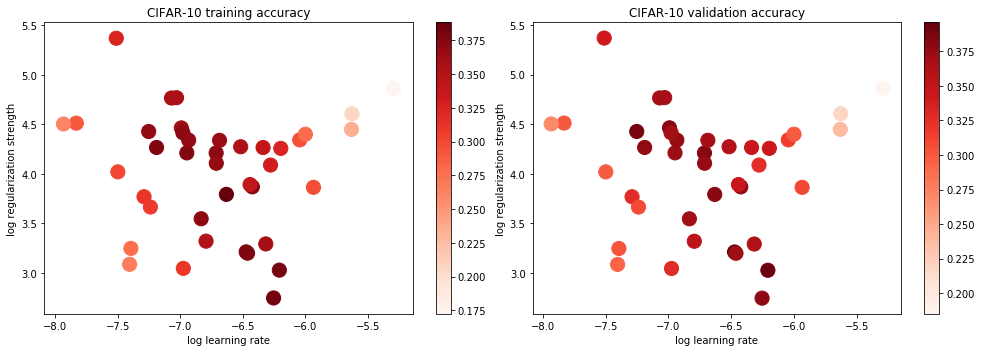

In [26]:
results = svm.results

# Visualize the cross-validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

plt.figure(figsize=(14,5))
# plot training accuracy
marker_size = 200
colors = [results[x][0] for x in results]
plt.subplot(1, 2, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.tight_layout() # tight layout

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(1, 2, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout() # tight layout
plt.show()

In [36]:
# Evaluate the best svm on test set
svm.W = svm.best_W
y_test_pred = svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.377000


In [34]:
loss_history = svm.train(X_train, y_train, num_iters=1225, learning_rate=3e-7, reg=1.5e3)

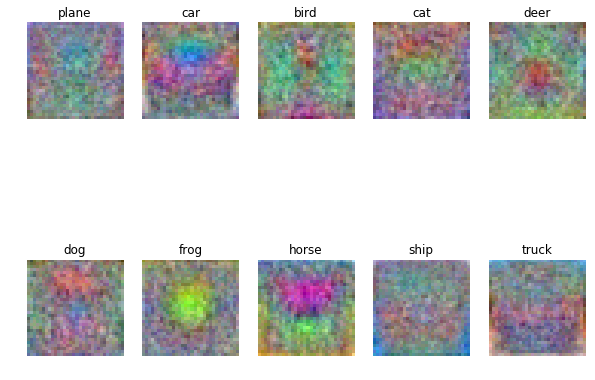

In [35]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *In order to increase the score for the correct class SVM weights try to increase inner product between X and W by trying to match those images, thus behaving as a universal template for particular class.*